# Определение стоимости автомобилей

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Цель**  
Разработать модель для быстрого и точного предсказания рыночной стоимости автомобилей с пробегом на основе исторических данных.
    
------
    
**Задачи**  
    
1. **Предобработка данных**  
   - Очистка и обработка пропусков  
   - Кодирование категориальных признаков  
    

2. **Анализ данных и feature engineering**  
   - Выделение значимых характеристик   
    

3. **Выбор и обучение модели**  
   - Тестирование алгоритмов (регрессия, деревья, бустинги)  
   - Оптимизация гиперпараметров  
    

4. **Оценка производительности**  
   - Метрики: RMSE, R²  
   - Проверка скорости предсказания  
   

##  Импорты и функции для работы

In [1]:
pip install --upgrade scikit-learn -q


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [83]:
#Импортируем необходимые библиотеки для работы 
import pandas as pd
from math import *
import numpy as np
from scipy import stats as st
# Метрики и оОбработка данных
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer

# Графическое отображение
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

# Модели обучения
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#Зададим константы
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [5]:
#Функция для отображения информации о датасете
def show_info(df):
    print('Количество строк выборки составляет:',df.shape[0],'\n')
    display('Первые пять строк', df.head())
    print('Общая информация о данных\n')
    print(df.info())
    display('Описание',df.describe().T)
    print('Количество явных дубликатов составляет',df.duplicated().sum())

In [6]:
# Функция для отображения уникальных значений в категориальных данных для поиска неявных дубликатов

def category_hide_duplicates(df):
    cat_col_names = df.select_dtypes(include='object').columns.tolist()
    for col in cat_col_names:
        print(col,':')
        print(df[col].unique())
        print('==================================')

In [7]:
# Введем Функцию для отображения пропущенных значений для явных дубликатов
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (10,5), legend = False)               

        );
        plt.title('Пропущенные значения, %' + "\n", fontsize=22)
        plt.xlabel('Процент пропусков', fontsize=18)
        plt.ylabel('Столбцы с пропусками',fontsize=18)
        plt.xlim(0, 100)  
    except:
        print('пропусков нет или произошла ошибка ')
        plt.title('Пропущенных значений нет', fontsize=32)

In [8]:
# Функция отображения гистограм и боксплотов для исследовательского анализа
def search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"{title_name}", fontsize=13)
    
    sns.histplot(df_col, bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(title_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    ax[0].axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].legend()

    sns.boxplot(x=df_col, ax=ax[1], color='pink')
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='green', linestyle='-.')
    ax[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    
    display(df_col.describe().T)
    print('')
    
    stat, p = st.shapiro(df_col)
    alpha = 0.1  # Уровень значимости
    if p > alpha:
        print("По тесту Шапиро-Уилка: Распределение похоже на нормальное")
    else:
        print("По тесту Шапиро-Уилка: Распределение отличается от нормального")

In [9]:
#Функция для построение круговых диаграмм
def search_сategory(df,col):
    
    ratio = round(df.groupby(col)[col].count()/df[col].count()*100)
    
    ratio.plot(
    kind = 'pie',
    autopct='%1.1f%%',
    labels = ratio.index,
    figsize=(6,6),
    title = 'Круговая диаграмма соотношения признаков в данных '+ col,
    ylabel = '',
    fontsize = 12
    )
    display(ratio)

In [10]:
# Функция для построение графиков с дискретными значениями
def discrete_search_plot(df_col, title_name):

    plt.figure(figsize=(12, 8))
    sns.color_palette("crest", as_cmap=True)
    
    fig = sns.countplot(df_col, x = title_name, edgecolor='black')
    fig.set_title(title_name, fontsize=14)
    fig.set_xlabel(title_name)
    fig.set_ylabel('Количество')
    fig.grid(True)



    plt.show()

In [11]:
#  Гистограмма распределения дат
def plot_date_histogram(df_col, title_name, bins=30, date_format='%Y-%m-%d'):

    # Проверка типа данных
    if not pd.api.types.is_datetime64_any_dtype(df_col):
        raise TypeError("Столбец должен быть в формате datetime!")
    
    # Расчет статистик
    min_date = df_col.min()
    max_date = df_col.max()
    date_range = max_date - min_date
    
    # Создание графика
    plt.figure(figsize=(12, 6))
    
    # Гистограмма распределения дат
    sns.histplot(df_col, bins=bins, kde=True, color='steelblue')
    plt.title(f'Гистограмма распределения дат: {title_name}', fontsize=14)
    plt.xlabel('Дата')
    plt.ylabel('Частота')
    plt.grid(True)
    
    # Форматирование оси дат
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(date_format))
    plt.xticks(rotation=10)
    
    # Вывод статистик
    stats_text = (f"Период данных: {min_date.strftime(date_format)} - {max_date.strftime(date_format)}\n"
                 f"Длительность: {date_range.days} дней\n"
                 f"Всего записей: {len(df_col)}")
    
    plt.figtext(0.5, 0.01, stats_text, ha='center', fontsize=10,
               bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 5})
    
    plt.tight_layout()
    plt.show()

In [12]:
#    Функция для создания круговой диаграммы, где отображаются топ-N категорий,
#    а остальные категории объединяются в группу 'others'.

def ratio (df, col, count):
    ratio = (
        round(
            df.groupby(col)[col].count()/
            df[col].count()*100)
        .sort_values(ascending = False)
        )

    ratio_top = ratio.head(count)
    others = pd.Series({'others': ratio[count:].sum()})
    final_ratio = pd.concat([ratio_top, others])

    colors = sns.color_palette('pastel', n_colors=count)# Цвета для топ
    colors.append('gray')# Отдельный цвет для "others"
    plt.figure(figsize=(8, 8))
    plt.pie(
        final_ratio,
        labels=final_ratio.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel')
           )
    plt.title('Круговая диаграмма данных '+ col)
    plt.show()

## Загрузка и подготовка данных

In [13]:
try:
    df = pd.read_csv('/datasets/autos.csv', sep =',')
except:
    df = pd.read_csv('autos.csv', sep =',')
    
raw_data_count = df.shape[0]

Обозначение полей в данных  

**Признаки:**
- **DateCrawled** — дата скачивания анкеты из базы  
- **VehicleType** — тип автомобильного кузова  
- **RegistrationYear** — год регистрации автомобиля  
- **Gearbox** — тип коробки передач  
- **Power** — мощность (л. с.)  
- **Model** — модель автомобиля  
- **Kilometer** — пробег (км)  
- **RegistrationMonth** — месяц регистрации автомобиля  
- **FuelType** — тип топлива  
- **Brand** — марка автомобиля  
- **Repaired** — была машина в ремонте или нет  
- **DateCreated** — дата создания анкеты  
- **NumberOfPictures** — количество фотографий автомобиля  
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)  
- **LastSeen** — дата последней активности пользователя  

**Целевой признак:**
- **Price** — цена (евро)  

In [14]:
show_info(df)

Количество строк выборки составляет: 354369 



'Первые пять строк'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  objec

'Описание'

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Количество явных дубликатов составляет 4


### Подытог загрузки данных

**Описание данных:**

В таблице представлены статистические характеристики числовых признаков автомобилей. Основные наблюдения:

- **Price**: Средняя цена составляет ~4417 евро, но разброс значительный (от 0 до 20000 евро). Медиана (2700 евро) ниже среднего, что указывает на правостороннюю асимметрию. Также цена авто в 0 нас не устраивает.
- **RegistrationYear**: Средний год регистрации — 2004, но есть аномалии (min=1000, max=9999). Медиана (2003) близка к среднему.
- **Power**: Средняя мощность — 110 л.с., но максимальное значение (20000 л.с.) явно ошибочно. Медиана (105 л.с.) подтверждает типичный диапазон.
- **Kilometer**: Большинство автомобилей имеют пробег 125000–150000 км (медиана и 75%-квантиль совпадают).
- **RegistrationMonth**: Распределение месяцев регистрации равномерное (медиана — июнь).
- **NumberOfPictures**: Все значения нулевые — признак неинформативен.


**Дубликаты:** Обнаружено 4 явных дубликата в данных.

### Предобработка данных

In [15]:
# Удалим явные дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [16]:
print('Количество явных дубликатов составляет:', df.duplicated().sum())

Количество явных дубликатов составляет: 0


In [17]:
#Преобразуем тип данных в датах
date_list = ['DateCrawled','DateCreated','LastSeen']
for date in date_list:
    df[date] = pd.to_datetime(df[date])

In [18]:
df[date_list].dtypes

DateCrawled    datetime64[ns]
DateCreated    datetime64[ns]
LastSeen       datetime64[ns]
dtype: object

#### выброс в дате регистрации

In [19]:
df.query('RegistrationYear < 1900 or RegistrationYear > 2025')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16,0,44628,2016-03-20 16:44:37
12946,2016-03-29 18:39:40,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN,2016-03-29,0,74523,2016-04-06 04:16:14
15147,2016-03-14 00:52:02,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-13,0,32689,2016-03-21 23:46:46
15870,2016-04-02 11:55:48,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-04-02,0,33649,2016-04-06 09:46:13
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29,0,47166,2016-04-06 10:44:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340544,2016-04-02 17:44:03,0,NaN,3500,manual,75,NaN,5000,3,petrol,sonstige_autos,NaN,2016-04-02,0,96465,2016-04-04 15:17:51
340755,2016-04-04 23:55:47,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04,0,86343,2016-04-05 06:44:07
341787,2016-03-28 17:37:30,1,NaN,3000,NaN,0,zafira,5000,0,NaN,opel,NaN,2016-03-28,0,26624,2016-04-02 22:17:49
348826,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21,0,41472,2016-04-05 14:18:01


Найдено 171 строк с некорректной датой. Удалим их

In [20]:
df = df.query('RegistrationYear > 1900 and RegistrationYear < 2025')

#### выброс мощности в 20000

In [21]:
df.query('Power == 20000')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
219583,2016-03-09 15:43:53,4300,coupe,1999,auto,20000,clk,150000,1,petrol,mercedes_benz,no,2016-03-09,0,19406,2016-03-30 08:47:08


In [22]:
power_mean_merc = round(df.query('Brand == "mercedes_benz" \
         and Model == "clk"\
         and VehicleType == "coupe"')\
        ['Power'].mean())
print('средняя мощность авто с идентичными параметрами:',power_mean_merc)

средняя мощность авто с идентичными параметрами: 197


Похоже, что хотели написать 200 и случайно добавили лишние нули. Заполню этот выброс средним значением

In [23]:
df.loc[df['Power'] == 20000,'Power'] = power_mean_merc

#### выбросы цена авто

Так как сервис должен предсказать стоимость автомобиля потенциального клиента, то вряд-ли клиента устроит, если его машину оценит в 0 ден.ед. Поэтому такие данные придется удалить из данных.

In [24]:
df = df.query('Price > 100')

### Обработка неявных дубликатов


In [25]:
category_hide_duplicates(df)

VehicleType :
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox :
['manual' 'auto' nan]
Model :
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'corsa' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' '

Неявных дубликатов не наблюдается. Перейдем к обработке пропущенных значений

#### Обработка пропусков

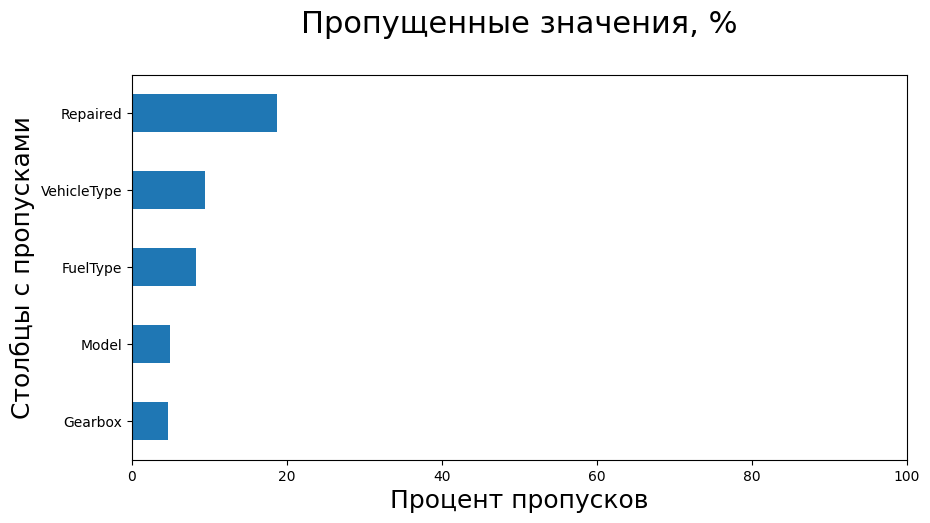

In [26]:
pass_value_barh(df)

Так как в `VehicleType` и `FuelType`  уже есть категория "other", то пропуски заполним этой меткой. В остальных категориальных данных поставим заглушку на неизвестное.

In [27]:
df['VehicleType'] = df['VehicleType'].fillna('other')

In [28]:
df['FuelType'] = df['FuelType'].fillna('other')

In [29]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

In [30]:
df['Model'] = df['Model'].fillna('unknown')

In [31]:
df['Repaired'] = df['Repaired'].fillna('unknown')

## Исследовательский анализ


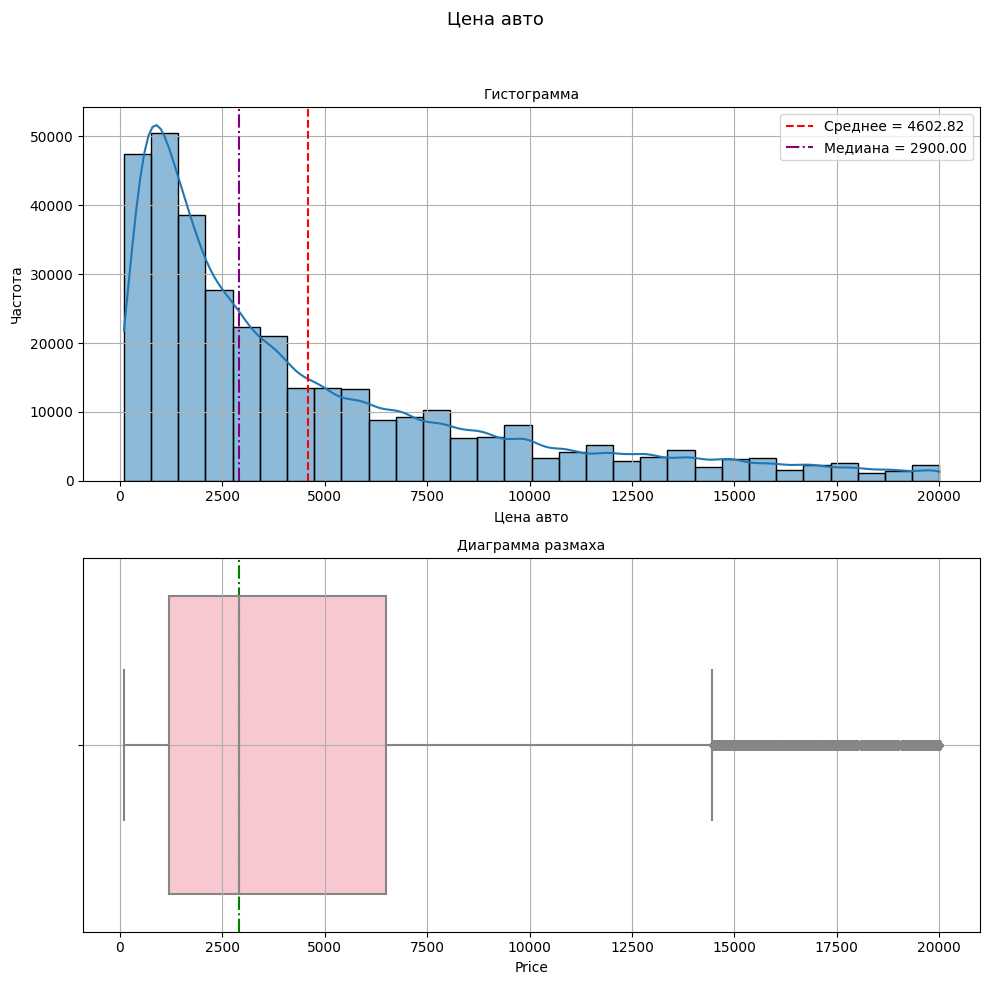

count    339909.000000
mean       4602.819469
std        4514.807096
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [32]:
search_plot(df['Price'], 'Цена авто',30)

**Выводы:**
1. **Асимметрия распределения**: Распределение цены имеет правостороннюю асимметрию, что указывает на наличие небольшого количества авто с высокой ценой.
3. **Выбросы**: Наличие выбросов может быть связано с уникальными и дорогими авто


--------

VehicleType
bus             8.0
convertible     6.0
coupe           5.0
other          10.0
sedan          26.0
small          23.0
suv             3.0
wagon          19.0
Name: VehicleType, dtype: float64

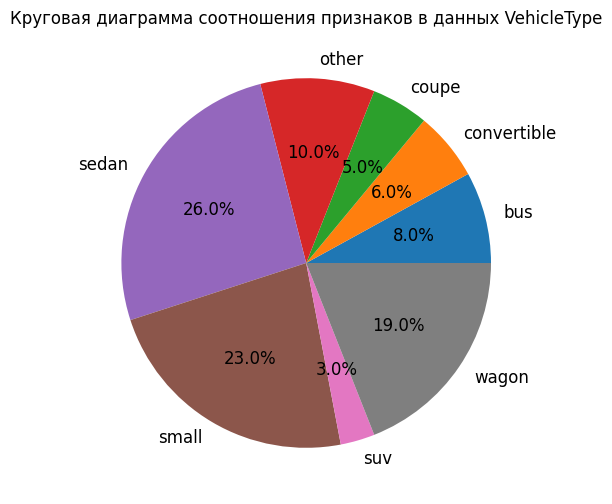

In [33]:
search_сategory(df,'VehicleType')

В выборке преобладают седаны, small и универсалы. 10% данных имеют значение `other`, что не есть хорошо, так как этой категории больше чем 4 определенных категории.

-----

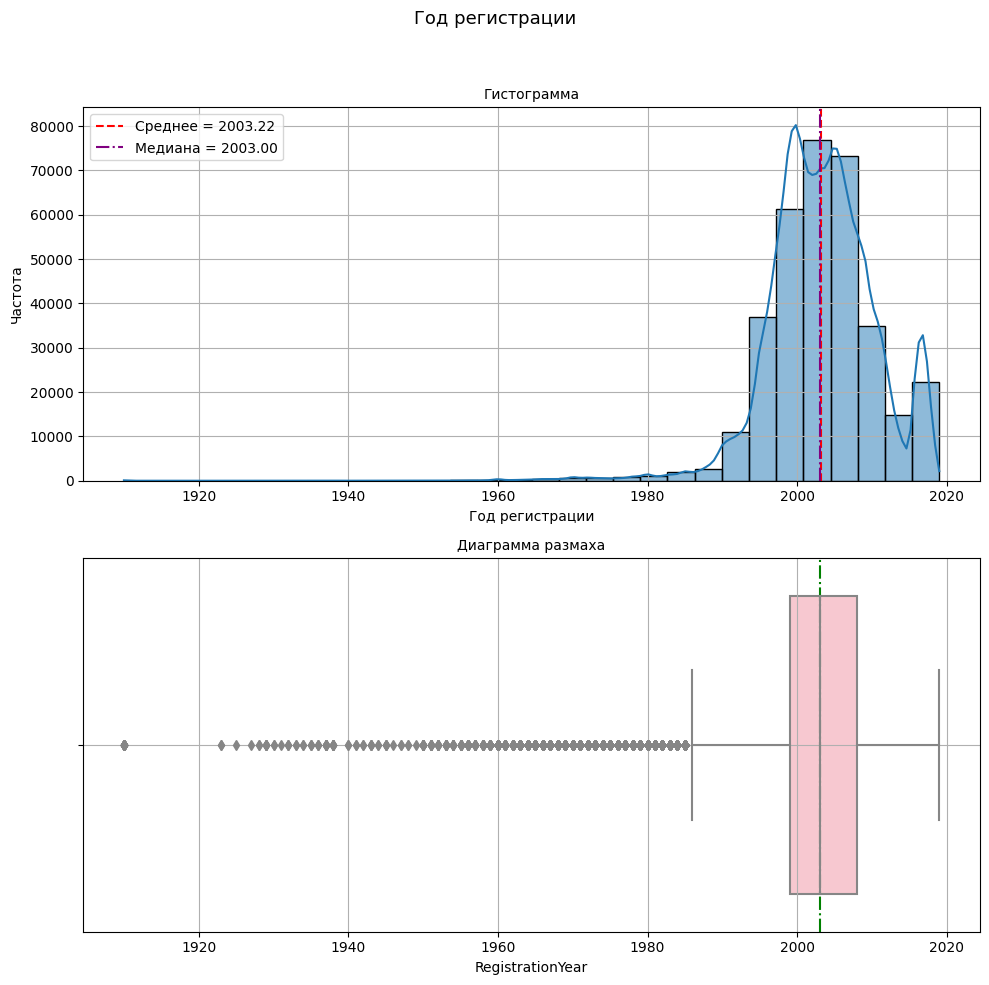

count    339909.000000
mean       2003.223883
std           7.305249
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [34]:
search_plot(df['RegistrationYear'], 'Год регистрации',30)

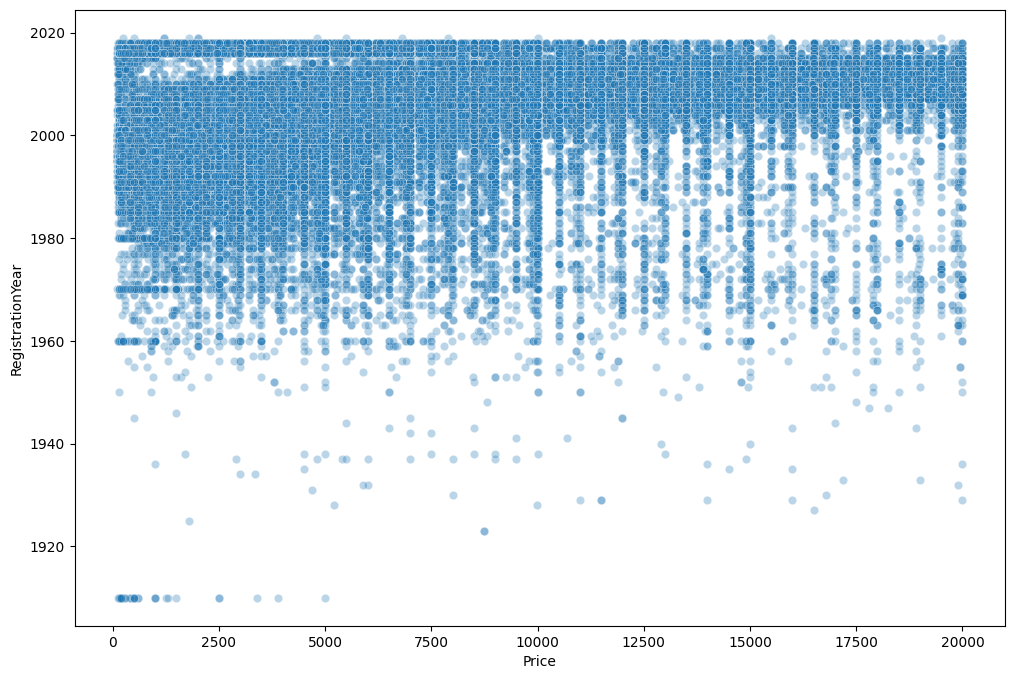

In [35]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
            data=df,
            x='Price',
            y='RegistrationYear',
#             hue = 'Model',
            alpha=0.3
        )
plt.show()

Есть выбросы из машин сделанных в прошлом веке. При этом цена автомобилей распределена от низкой до самых высоких цен, что гооврит о том, что мы имеем дело с коллекционными автомобилями. Такие данные не совсем акутальны в приложении, так как медианное и среднее значение равны. Сократим данные, выбрав авто с 1980 года.

In [36]:
df = df.query('RegistrationYear>=1980')

-----------------

Gearbox
auto       19.0
manual     76.0
unknown     5.0
Name: Gearbox, dtype: float64

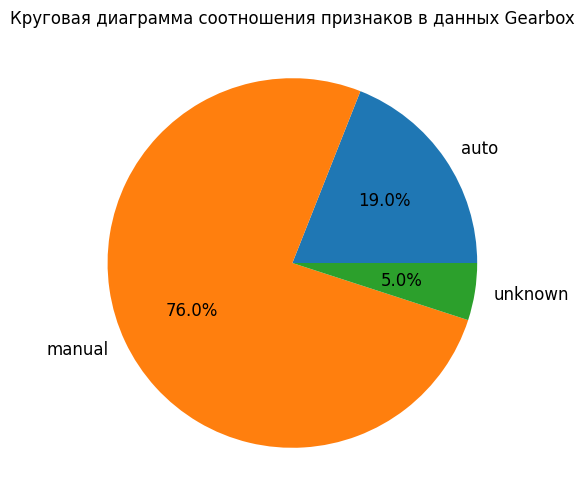

In [37]:
search_сategory(df,'Gearbox')

Наблюдается дисбаланс в сторну ручных коробок передач

-----

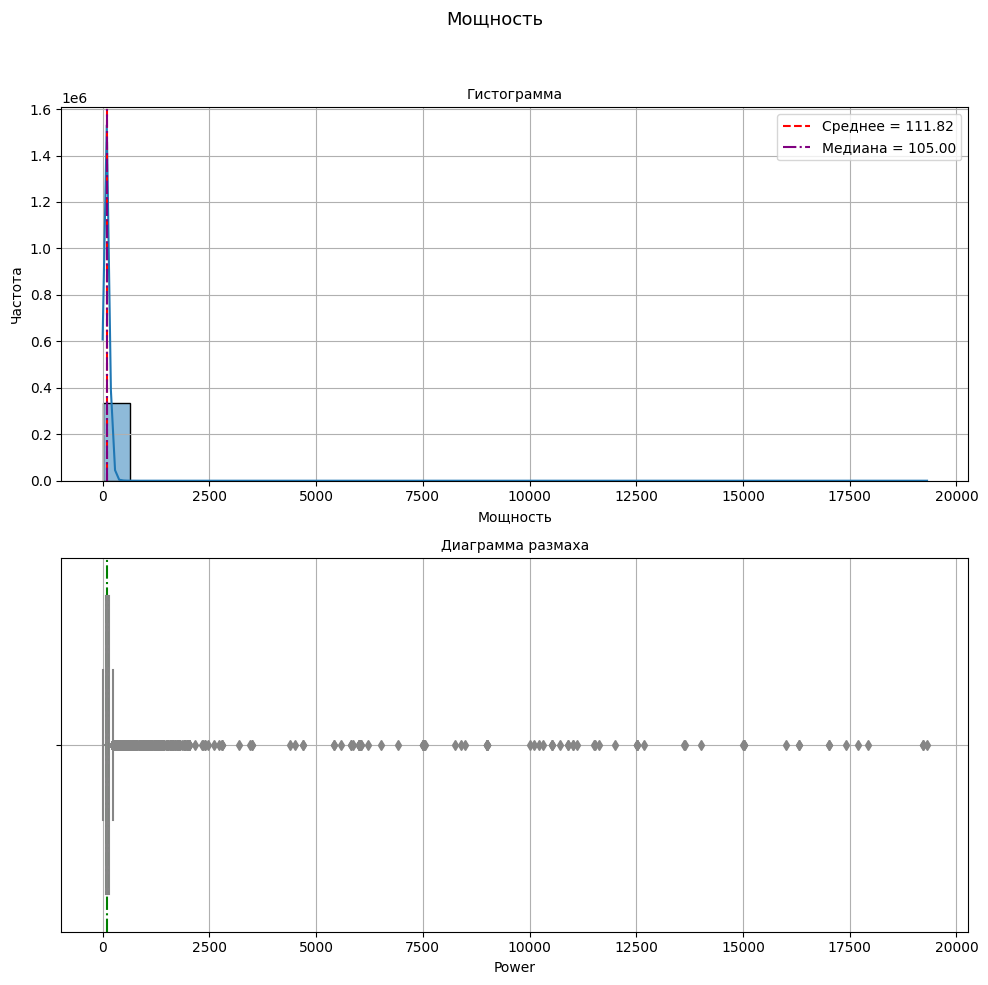

count    336892.000000
mean        111.815834
std         183.893247
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       19312.000000
Name: Power, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [38]:
search_plot(df['Power'], 'Мощность', 30)

Значения >1000 л.с. встречаются только у гиперкаров или спецтехники. Заполним значения мощности, если он выше 1000 медианным значением по типу кузова.

In [39]:
median_power_by_type = df.groupby('VehicleType')['Power'].median()


In [40]:
for vehicle_type in median_power_by_type.index:
    mask = (df['VehicleType'] == vehicle_type) & (df['Power'] > 1000)
    df.loc[mask, 'Power'] = median_power_by_type[vehicle_type]
    
    mask_zero = (df['VehicleType'] == vehicle_type) & (df['Power'] == 0)
    df.loc[mask_zero, 'Power'] = median_power_by_type[vehicle_type]
    
print(df['Power'].describe())
 

count    336892.00000
mean        117.95281
std          52.97598
min           1.00000
25%          75.00000
50%         110.00000
75%         143.00000
max        1000.00000
Name: Power, dtype: float64


-----

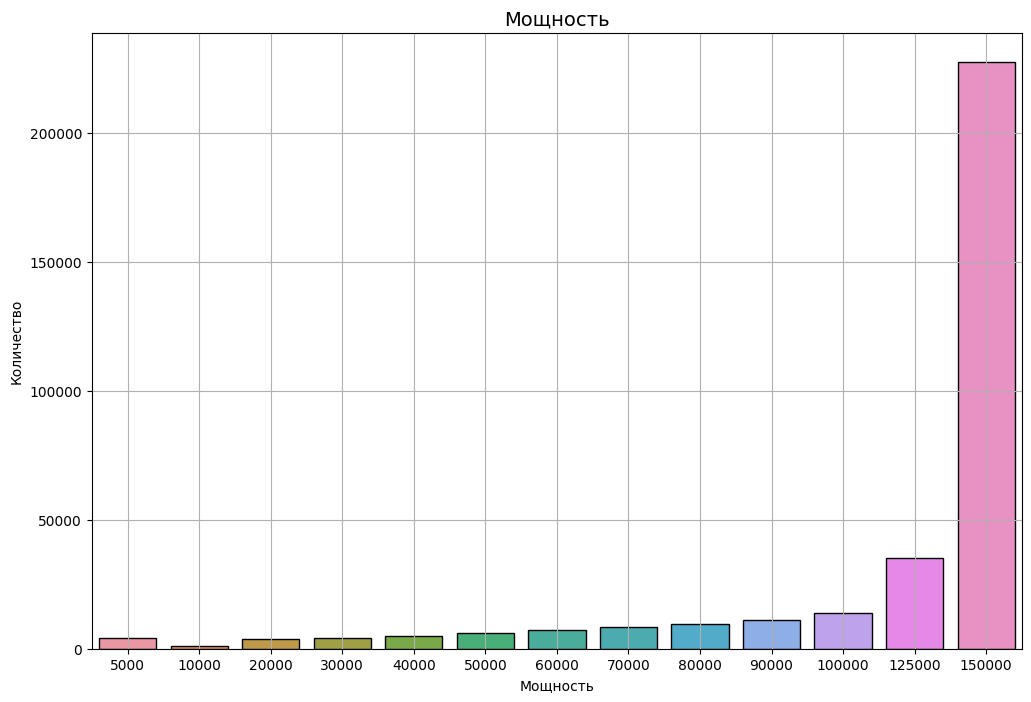

In [41]:
discrete_search_plot(df['Kilometer'], 'Мощность')

Складывается мнение, что нельзя написать определенуую цифру пробега автомобиля и 150к это максимальный возмлнжный выбор. Нужно уточнить эту информаию у тех кто собирает данные

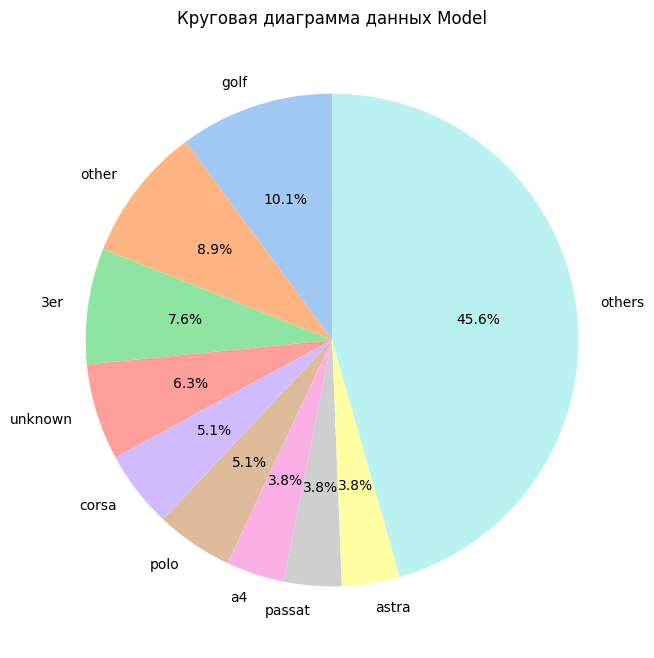

In [42]:
ratio(df,'Model',9)

Нечего добавить, кроме того как представлено большое разнообразие моделей. Также можно отметить большое количество неизвестных моделей авто.

FuelType
cng          0.0
electric     0.0
gasoline    29.0
hybrid       0.0
lpg          2.0
other        8.0
petrol      61.0
Name: FuelType, dtype: float64

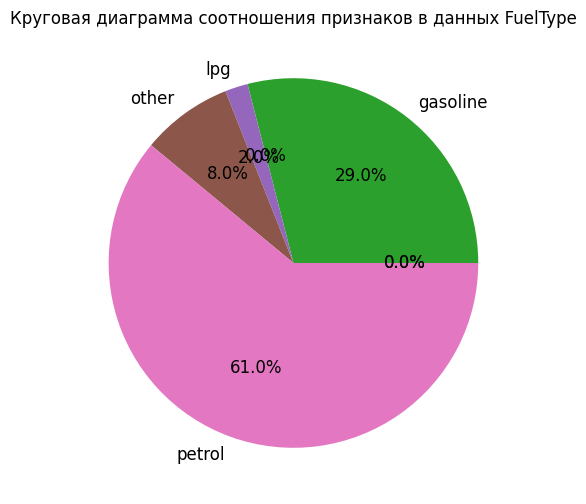

In [43]:
search_сategory(df,'FuelType')

Большое количество машин имеет тмп топлива бензин или дизель. Электромобили практически не встречаются.

Repaired
no         72.0
unknown    19.0
yes        10.0
Name: Repaired, dtype: float64

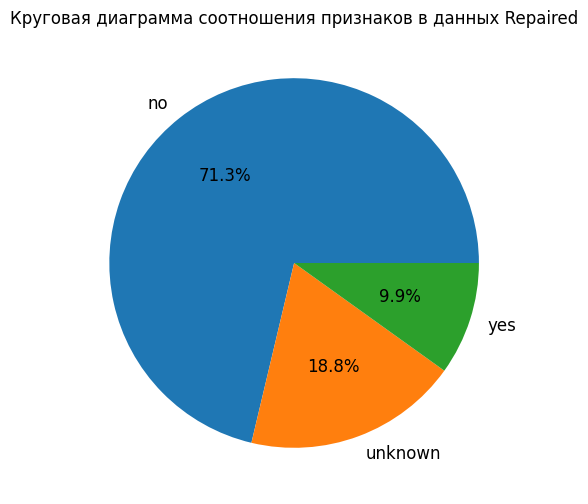

In [44]:
search_сategory(df,'Repaired')

Признаки DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen -- считаю не информативными для использования в МО и их удалим из выборки

In [45]:
lst_to_delete = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen','RegistrationMonth']

In [46]:
df = df.drop(columns=lst_to_delete)

In [47]:
df.head(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,other,1993,manual,75,golf,150000,petrol,volkswagen,unknown


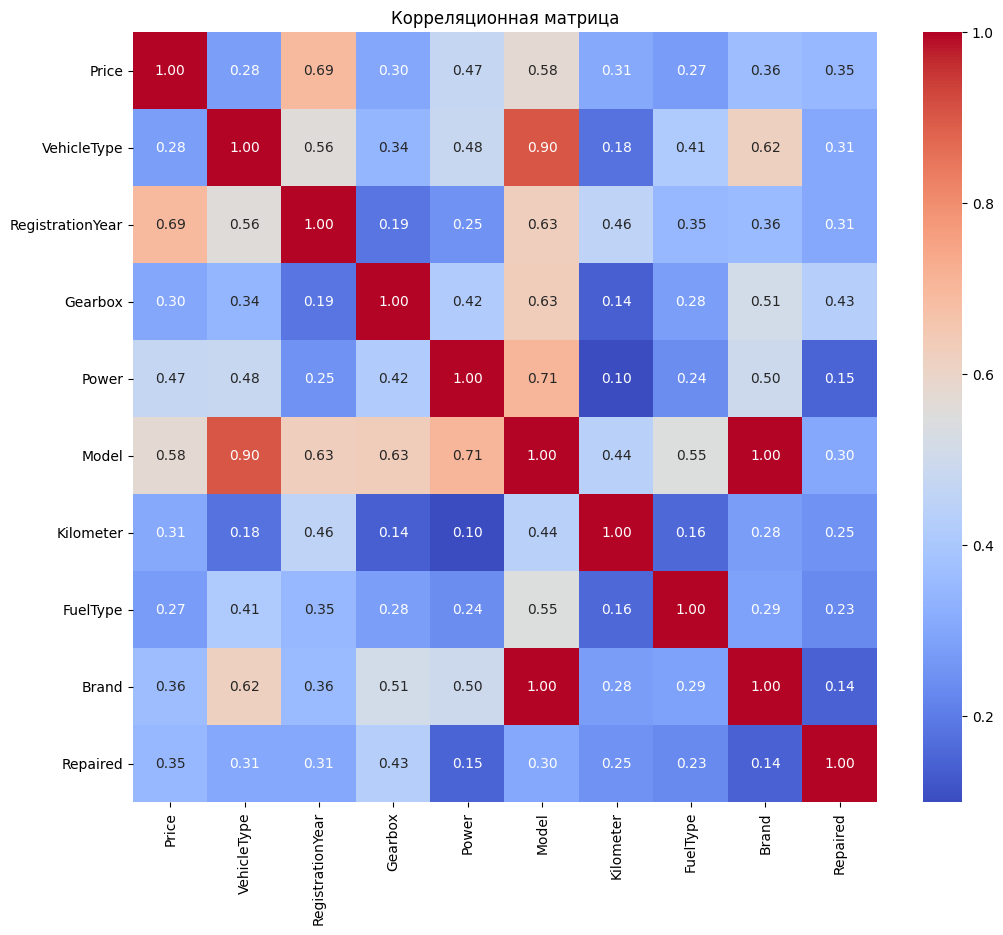

In [48]:
phik_matrix = df.phik_matrix(interval_cols=['Price','RegistrationYear','Power','Kilometer'])

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

---
C целевым признаком есть умеренная корреляция со следующими признаками:    
- `RegistrationYear`
- `Model`
- `Power`
---

In [49]:
print(
    'В результате обработки данных было потеряно',
    round(
        (1 - df.shape[0]/raw_data_count) *100,2
    ), 
    '% данных'
)

В результате обработки данных было потеряно 4.93 % данных


## Обучение моделей

### Подготовка данных к МО

In [50]:
print('размер тренировочной выборки(строк, столбцов):', df.shape)
df.head(1)

размер тренировочной выборки(строк, столбцов): (336892, 10)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,other,1993,manual,75,golf,150000,petrol,volkswagen,unknown


In [51]:
X = df.drop(['Price'], axis=1)
y = df['Price']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

In [53]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
ohe_columns = X_train.select_dtypes(include='object').columns.tolist()
category_features = X_train.select_dtypes(include='object').columns.tolist()

In [54]:
k = 5  # Количество фолдов
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Не бустинговые модели

#### Пайплайн

In [55]:
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False)
        )
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
        ], remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [138]:
param_grid_tree = [
    # Гиперпараметры DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 7, 10, None],
        'models__min_samples_leaf': [2, 4],
        'models__max_features': [0.5, 1]
    }
]
param_linear = [
     # Гиперпараметры LinearRegression
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'models__positive': [True, False]  
    }
]    

#### Деревья

In [57]:
gs_tree = GridSearchCV(
    pipe_final, 
    param_grid_tree, 
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [68]:
%%time
gs_tree.fit(X_train, y_train)

CPU times: total: 9.17 s
Wall time: 8min 49s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('SimpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleTyp...
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer'])])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': [3, 7, 10, None],
                          'models__max_features': [0.5, 1],
                          'models__min_samples_leaf': [1, 2, 4]}],
             scoring='neg_root_mean_squared_error')

In [69]:
print('Лучшая модель и её параметры:\n\n', gs_tree.best_estimator_)
print ('Метрика лучшей модели на кросс валидации:', gs_tree.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                 

In [86]:
%%time
# Предсказание на тестовых данных
y_pred_tree = gs_tree.best_estimator_.predict(X_test)


CPU times: total: 266 ms
Wall time: 338 ms


In [139]:
time_train_tree=480+49
time_pred_tree=266

In [87]:
# Оценка точности
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
tree_r2 = r2_score(y_test, y_pred_tree)
print(f"Точность модели: {tree_rmse:.5f}")
print(f"Точность модели: {tree_r2:.5f}")

Точность модели: 1750.12841
Точность модели: 0.84780


#### Linear Regression

In [134]:
gs_lr = GridSearchCV(
    pipe_final, 
    param_linear, 
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)

In [142]:
%%time
gs_lr.fit(X_train, y_train)

CPU times: total: 11.6 s
Wall time: 10min 25s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('SimpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer'])])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'models__fit_intercept': [True, False],
                          'models__positive': [True, False]}],
             scoring='neg_root_mean_squared_error')

In [143]:
print('Лучшая модель и её параметры:\n\n', gs_lr.best_estimator_)
print ('Метрика лучшей модели на кросс валидации:', gs_lr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                 

In [144]:
%%time
# Предсказание на тестовых данных
y_pred_lr = gs_lr.best_estimator_.predict(X_test)

# Оценка точности
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Точность модели: {tree_rmse:.5f}")
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Точность модели: {r2_lr:.5f}")

Точность модели: 1750.12841
Точность модели: 0.68744
CPU times: total: 93.8 ms
Wall time: 300 ms


In [145]:
time_train_lr=600+25
time_pred_lr=300

### LightGBM

In [59]:
category_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [60]:
for col in category_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [61]:
model_lgbm = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    categorical_feature=category_features,
    n_estimators=100,
    random_state=42,
    verbose=-1  # отключаем вывод логов
)

# Задаём сетку гиперпараметров
param_grid_lgbm = {
    'learning_rate': [0.01, 0.1],
    'num_leaves': [15, 31],
    'max_depth': [5, 10],  # -1 = нет ограничения
    'min_data_in_leaf': [10, 20],
    'reg_alpha': [0, 0.5],  # L1-регуляризация (lambda_l1)
#     'reg_lambda': [0, 0.5],  # L2-регуляризация (lambda_l2)
#     'feature_fraction': [0.8, 1.0]
}


# Настраиваем GridSearchCV с RMSE
grid_search = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring='neg_root_mean_squared_error',  # минимизируем RMSE (чем ближе к 0, тем лучше)
    cv=kf,  # 5-фолдная кросс-валидация
    n_jobs=-1 
)

In [62]:
%%time
# Запускаем подбор параметров
grid_search.fit(X_train, y_train)



CPU times: total: 6.48 s
Wall time: 3min 31s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(categorical_feature=['VehicleType',
                                                          'Gearbox', 'Model',
                                                          'FuelType', 'Brand',
                                                          'Repaired'],
                                     objective='regression', random_state=42,
                                     verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 10],
                         'min_data_in_leaf': [10, 20], 'num_leaves': [15, 31],
                         'reg_alpha': [0, 0.5]},
             scoring='neg_root_mean_squared_error')

In [72]:
# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print ('Метрика лучшей модели на кросс валидации:', grid_search.best_score_*(-1))

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'min_data_in_leaf': 20, 'num_leaves': 31, 'reg_alpha': 0}
Метрика лучшей модели на кросс валидации: 1631.246994750883


In [64]:
%%time
# Предсказание на тесте
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

CPU times: total: 750 ms
Wall time: 124 ms


In [146]:
time_pred_lgb = 180+31
time_train_lgb = 124

In [88]:
# Считаем RMSE
rmse_gbm = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE на тестовых данных: {rmse:.4f}")
# Оценка точности
r2_gbm = r2_score(y_test, y_pred)
print(f"Точность модели: {tree_r2:.5f}")


RMSE на тестовых данных: 1620.1193
Точность модели: 0.84780


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

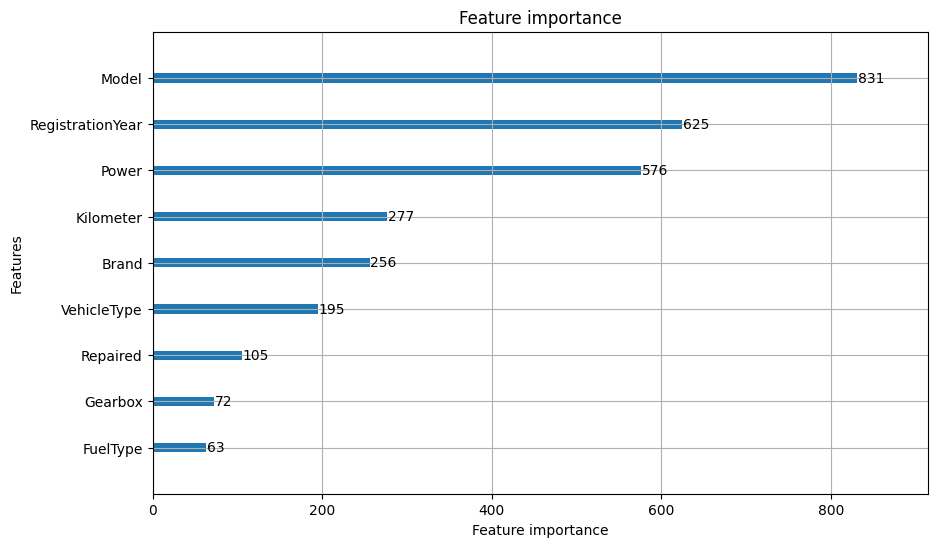

In [67]:
lgb.plot_importance(best_model, figsize=(10, 6))

**Важными признаками являются:**    
1) Модель авто    
2) Время регистрации авто    
3) Мощность    
4) Пробег    
5) Бренд

### Catboost


In [76]:
from catboost import Pool

In [77]:
train_pool = Pool(data=X_train, label=y_train, cat_features=category_features)
val_pool = Pool(data=X_test, label=y_test,cat_features=category_features)

In [91]:
model_catb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=7,
    loss_function='RMSE',
    eval_metric='R2',
    l2_leaf_reg = 4,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

# Обучение модели
model_catb.fit(train_pool, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1305337	test: 0.1309573	best: 0.1309573 (0)	total: 181ms	remaining: 1m 30s
100:	learn: 0.8531618	test: 0.8527173	best: 0.8527173 (100)	total: 15.1s	remaining: 59.8s
200:	learn: 0.8657531	test: 0.8631250	best: 0.8631250 (200)	total: 30.4s	remaining: 45.2s
300:	learn: 0.8725694	test: 0.8683091	best: 0.8683091 (300)	total: 45.4s	remaining: 30s
400:	learn: 0.8766264	test: 0.8711362	best: 0.8711362 (400)	total: 1m	remaining: 15s
499:	learn: 0.8795354	test: 0.8730062	best: 0.8730095 (498)	total: 1m 15s	remaining: 0us

bestTest = 0.8730095127
bestIteration = 498

Shrink model to first 499 iterations.


In [92]:
%%time
# Предсказание на тесте
y_pred_catb = model_catb.predict(X_test)

CPU times: total: 344 ms
Wall time: 78.8 ms


In [141]:
time_pred_catb = 75
time_train_catb = 78

In [100]:
# Считаем RMSE
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catb))
print(f"RMSE на тестовых данных: {rmse_catboost:.4f}")
# Оценка точности
r2_catboost = r2_score(y_test, y_pred_catb)
print(f"Точность модели: {r2_catboost:.5f}")

RMSE на тестовых данных: 1598.6142
Точность модели: 0.87301


## Анализ моделей

In [152]:
rmse_lst= [tree_rmse, rmse_lr,rmse_gbm,rmse_catboost]
r2_lst = [tree_r2,r2_lr,r2_gbm,r2_catboost]

In [153]:
# Данные
data = {
    "Model": ["DecisionTree", "LinearRegression", "LGBM", "CatBoost"],
    "R² Score": r2_lst,
    "RMSE": rmse_lst,
    "time to train, sec": [time_train_tree, time_train_lr,time_train_lgb,time_train_catb],
    "time to test, ms": [time_pred_tree, time_pred_lr,time_pred_lgb,time_pred_catb]
}

# Создаем DataFrame
metrics_df = pd.DataFrame(data)

# Устанавливаем Model в качестве индекса (чтобы было как в вашем описании)
metrics_df.set_index("Model", inplace=True)

# Транспонируем, если нужно метрики в строках, а модели в столбцах
metrics_df = metrics_df  # Если нужно поменять местами строки и столбцы

display(metrics_df)

,R² Score,RMSE,"time to train, sec","time to test, ms"
Model,,,,
DecisionTree,0.847797,1750.128413,529,266
LinearRegression,0.687443,2507.970026,625,300
LGBM,0.869570,1620.119336,124,211
CatBoost,0.873010,1598.614186,78,75


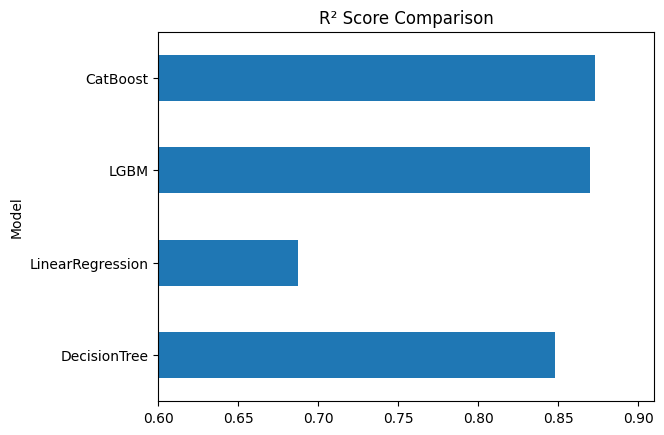

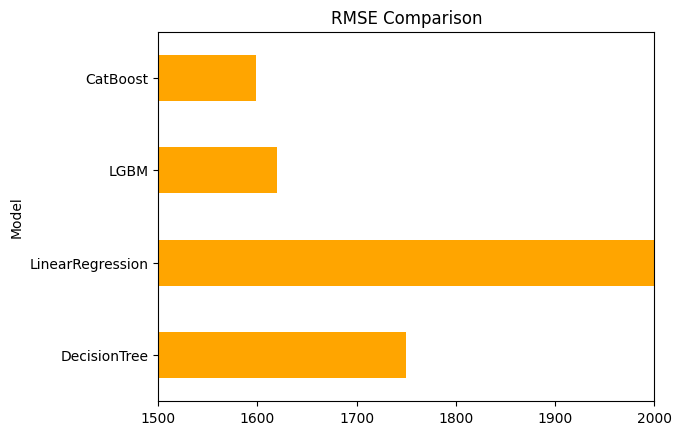

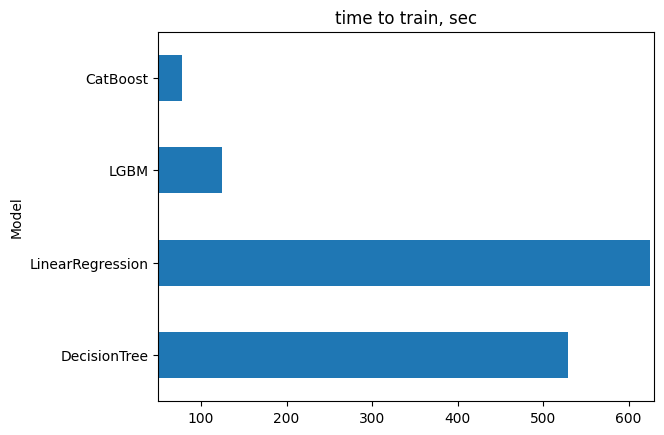

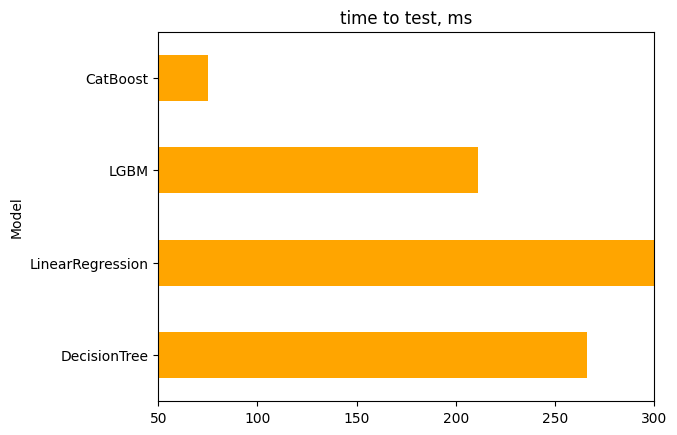

In [157]:
# Построение для R² Score
metrics_df['R² Score'].plot(kind='barh', title='R² Score Comparison')
plt.xlim(0.6, 0.91)  # Ограничение оси Y для R²
plt.show()

# Построение для RMSE
metrics_df['RMSE'].plot(kind='barh', title='RMSE Comparison', color='orange')
plt.xlim(1500, 2000)  # Ограничение оси Y для R²
plt.show()

# Построение для time train
metrics_df['time to train, sec'].plot(kind='barh', title='time to train, sec')
plt.xlim(50, 630)  # Ограничение оси Y для R²
plt.show()

# Построение для test time
metrics_df['time to test, ms'].plot(kind='barh', title='time to test, ms', color='orange')
plt.xlim(50, 300)  # Ограничение оси Y для R²
plt.show()

##  Итоговый анализ

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Цель**  
Разработать модель для быстрого и точного предсказания рыночной стоимости автомобилей с пробегом на основе исторических данных.
    
------
    
**Лучшая модель:**  
    
1. **CatBoost**
    - **R2** - 0.84  
    - **RMSE** - 1598 
    - **Время обучения** - 78 сек
    - **Время проверки тестовых данных** - 75 мс
    
    
2. На втором месте оказался `LightGBM`, затем `DesicionTree`  и `LinearRegression` на последнем месте.

    
**Вывод**
    
1. Поставленная задача выполнена, итоговая метрика **RMSE** меньше 2500 по итогам трех моделей (за исключение линейной регрресии).
2. Обучены бустинговые модели и простые модели.
3. Проведен сравнительный анализ.    
    
**Рекомендации**
    
Для корректного использования модели в текущее время нужно использовать коэффициент, учитывающий инфляцию стоимости автомобилей или же передать новые акутальные данные по автомобилям.   

